## Task 1 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [4]:
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [5]:

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w

In [10]:
def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)

In [11]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


In [12]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


In [13]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")




Epoch: 0
Mean Train Loss: 4.03e-01
Mean Test Loss:  1.87e-01
Epoch: 10
Mean Train Loss: 1.49e-01
Mean Test Loss:  2.71e-01


KeyboardInterrupt: 

<div style="color: green; font-weight: bold">Essentially same plot</div>

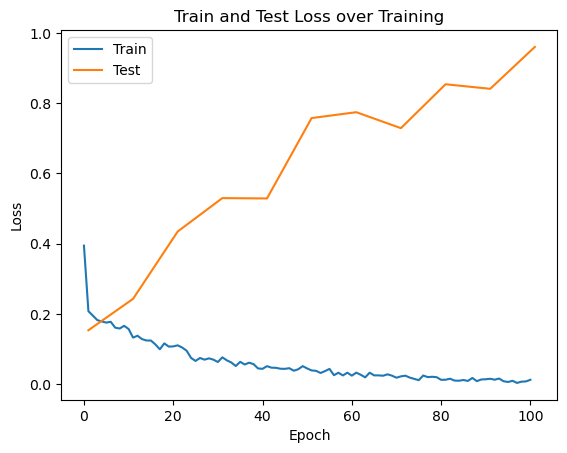

In [ ]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Task 2 Dropout

<div style="color: green; font-weight: bold">Exception is missing otherwise essentially the same as sample</div>

In [13]:
def dropout(X, p_drop=0.5):
    # use only pytorch tensors not list iteration otherwise the backpropagation is wrong
    mask = torch.rand_like(X) > p_drop
    output = X * mask / (1 - p_drop)
    return output

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [125]:
def dropout_model(X, w_h , w_h2 , w_o , p_drop_input , p_drop_hidden ):
    h_0 = dropout(X, p_drop_input)
    h = rectify(h_0 @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [126]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.5, 0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                # set dropout to 0 
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.0, 0.0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 625])
torch.Size([100, 10])
----------------------
torch.Size([100, 784])
torch.Size([784, 

KeyboardInterrupt: 

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

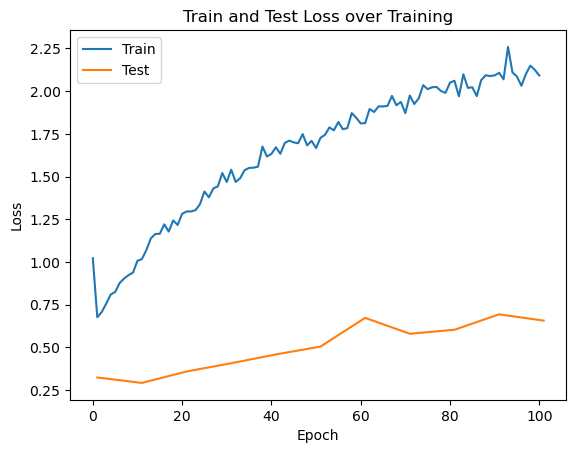

In [76]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

### Comparing the losses with and without dropout
The training loss for the model without the dropouts is lowering each epoch whilest the test error is going up, indicating that overfitting is happening. The increase of the loss of the model with dropout layers is more evenly (Both,training and test error is increasing a bit over time), indicating that the issue of overfitting has been tackled. The test loss is all the time significantly lower than the tain loss,because the test model is "better" since it can use all its neurons instead of only a fraction.

### How dropout works 
By setting some fraction of the neurons of a neural network to 0, a diverse set of smaller networks is created, forcing the remaining neurons to learn more robust and independent features. By doing so, dropout prevents the network from relying too heavily on specific neurons, thus reducing overfitting and improving generalization performance. 

### Why we need different model for the test loss
We need for the test model to have the dropout rate set to 0 since we want to harness every neuron in the netowrk. Only during training time ew want to actually drop neurons.

# Task 3 Parametric Relu

<div style="color: green; font-weight: bold">Sample solution uses a.requires_grad in seperate function and doesn't touch RMSprop_prelu class.</div>

In [51]:
class RMSprop_prelu(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example and also updates a from prelu
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8, momentum=0.9):
        defaults = dict(lr=lr, alpha=alpha, eps=eps, momentum=momentum)
        super(RMSprop_prelu, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups: 
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # Calculations for original w matrices
                if len(torch.flatten(p)) != 1:
                    # state initialization
                    if len(state) == 0:
                        state['square_avg'] = torch.zeros_like(p.data)

                    square_avg = state['square_avg']
                    alpha = group['alpha']

                    # update running averages
                    square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                    avg = square_avg.sqrt().add_(group['eps'])

                    # gradient update
                    p.data.addcdiv_(grad, avg, value=-group['lr'])
                    
                # Calculation for a of PRelu
                elif len(torch.flatten(p)) == 1:
                    # update a as in paper
                    # grad = Gradient ∂E/∂ai
                    delta_a = group['momentum'] * p.data + group['lr'] * grad
                    p.data -= delta_a

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [52]:
def PRelu(X, a): 
    # Parametric Rectified Linear Unit (PReLU)
    return torch.max(torch.zeros_like(X), X) + a * torch.min(torch.zeros_like(X), X)

<div style="color: green; font-weight: bold">Essentially the same as sample solution.</div>

In [55]:
def dropout_prelu_model(X, w_h , w_h2 , w_o , p_drop_input , p_drop_hidden, a):
    h_0 = dropout(X, p_drop_input)
    h = PRelu(h_0 @ w_h, a=a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a=a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2@ w_o
    return pre_softmax


<div style="color: green; font-weight: bold">Same idea as sample solution with initializing a but only as tensor with one element instead of using (batch size, 625), however a.requires_grad is also used.</div>

In [56]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
# coefficient controlling the slope of the negative Relu part
# init = 0.25 as in paper https://arxiv.org/pdf/1502.01852.pdf
a = torch.tensor([[0.25]])
a.requires_grad = True

optimizer = RMSprop_prelu(params=[w_h, w_h2, w_o, a])
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_prelu_model(x, w_h, w_h2, w_o, 0.5, 0.5, a)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                # set dropout to 0 
                noise_py_x = dropout_prelu_model(x, w_h, w_h2, w_o, 0.0, 0.0, a)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")


Epoch: 0
Mean Train Loss: 1.02e+00
Mean Test Loss:  3.59e-01
Epoch: 10
Mean Train Loss: 7.10e-01
Mean Test Loss:  2.49e-01
Epoch: 20
Mean Train Loss: 7.26e-01
Mean Test Loss:  2.27e-01
Epoch: 30
Mean Train Loss: 7.68e-01
Mean Test Loss:  2.76e-01
Epoch: 40
Mean Train Loss: 7.97e-01
Mean Test Loss:  3.07e-01
Epoch: 50
Mean Train Loss: 8.54e-01
Mean Test Loss:  2.75e-01
Epoch: 60
Mean Train Loss: 8.45e-01
Mean Test Loss:  2.32e-01
Epoch: 70
Mean Train Loss: 8.61e-01
Mean Test Loss:  1.89e-01
Epoch: 80
Mean Train Loss: 9.27e-01
Mean Test Loss:  1.98e-01
Epoch: 90
Mean Train Loss: 9.42e-01
Mean Test Loss:  2.13e-01
Epoch: 100
Mean Train Loss: 9.28e-01
Mean Test Loss:  3.42e-01


<div style="color: green; font-weight: bold">Because of the previously mentioned wrong initialization, the train and test loss is wrong in our solution</div>

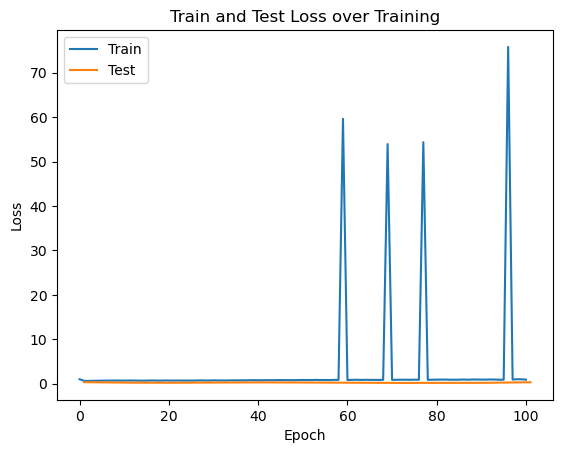

In [57]:
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">
The rest of the exercises are missing completely 
</div>

### Comparing the losses with PReLU
The usage of the PReLU should in theory help reduce dead neurons and the dying ReLU problem, improve gradient flow, and is less sensitive to initialization. Empirical evidence also demonstrates its better performance in enhancing convergence speed and accuracy. However, as we can see the train and test loss over training doesn't look very promising. This is most likely a problem of the implemented gradient function for the calculation of the parameter a used in PReLU. 